# Test models on unseen data

## Overall process

Split a segment into 2000 datapoints. For each split,

* Noise reduction using ICA algorithm (fastICA from sklearn)
* Wavelet transform
* Features extraction (mean absolute value, average power, standard deviation, variance, mean, skewness, and Shannon entropy)
* Pass through a pretrained model and see if the predicted classes are the same over multiple attempts (we don't know the stage of the segment, only that it is preictal).

## Imports

In [1]:
import pywt
from os import listdir, path, walk, makedirs
import random
import numpy as np
from pyentrp import entropy
from scipy.stats import median_absolute_deviation
from sklearn.preprocessing import RobustScaler
import pandas as pd
import scipy.io
from scipy.signal import spectrogram
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, make_scorer
import xgboost as xgb

In [3]:
import pickle

## ICA noise reduction

In [4]:
from sklearn.decomposition import FastICA

## Feature extraction

In [5]:
# mean absolute value, average power, standard deviation, variance, mean, skewness, and Shannon entropy

In [6]:
def flatten_list(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [7]:
def mean_absolute_value(array):
    absolute_values = []
    for i in range(len(array)):
        absolute_values.append(abs(array[i]))
    mean_absolute_value = np.asarray(absolute_values).sum()*(1/len(array))
    #print(mean_absolute_value)
    return mean_absolute_value

In [8]:
def average_power(array):
    average_power_values = []
    for i in range(len(array)):
        average_power_values.append(abs(array[i])**2)
    average_power_value = np.asarray(average_power_values).sum()*(1/len(array))
    #print(average_power_value)
    return average_power_value

In [9]:
def shan(d1):
    sh1=[]
    d1=np.rint(d1)
    for i in range(d1.shape[0]):
        X=d1[i]
        sh1.append(entropy.shannon_entropy(X))
    return(sh1)

In [10]:
def feature_extraction(decomposed_signals):
    mav = []
    avp = []
    std = []
    var = []
    mean = []
    for coeff in decomposed_signals:
        mav_electrode = []
        avp_electrode = []
        std_electrode = []
        var_electrode = []
        mean_electrode = []
        for electrode in coeff:
            mav_electrode.append(mean_absolute_value(electrode))
            avp_electrode.append(average_power(electrode))
            std_electrode.append(np.std(electrode))
            var_electrode.append(np.var(electrode))
            mean_electrode.append(np.mean(electrode))
        mav.append(mav_electrode)
        avp.append(avp_electrode)
        std.append(std_electrode)
        var.append(var_electrode)
        mean.append(mean_electrode)
    mav = flatten_list(mav)
    avp = flatten_list(avp)
    std = flatten_list(std)
    var = flatten_list(var)
    mean = flatten_list(mean)
    shan_ent = []
    for i in range(len(decomposed_signals)):
        shan_ent.append(shan(coeffs[i]))
    shan_ent = flatten_list(shan_ent)
    data = np.vstack((np.array(mav), np.array(avp), 
                     np.array(std), np.array(var), np.array(mean), np.array(shan_ent)))
    #data = pd.DataFrame(data)
    features = data.T
    #features.columns = ['mean_abs_value', 'average_power', 'std', 'var', 'mean', 'shannon_entropy']

    return features

In [11]:
import re 

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
    return l

 ## Split segment

In [68]:
from scipy.io import loadmat
from scipy.signal import decimate

data = loadmat("Dog_3_preictal_segment_0003.mat")
data = data['preictal_segment_3'][0][0][0]

In [69]:
data = decimate(data,10)

In [70]:
segment_size = 2000

filenumber = 1
temp = pd.DataFrame(data)

#temp = pd.read_csv('test_segment_21.csv')
    
for j in range(temp.shape[0]):   #iterate through all sensors
    idx = 0
    while idx + segment_size <= len(temp.iloc[0]):
        segment = temp.iloc[j][idx:idx + segment_size]
        segment.to_csv(f'test_segment_split_csv/{filenumber}.csv')

        filenumber += 1
        idx = idx + segment_size


#change filename as required, ensure the target directory is empy

segment_size = 2000

filenumber = 1

temp = pd.read_csv('test_segment_21.csv')
    
for j in range(temp.shape[0]):   #iterate through all sensors
    idx = 0
    while idx + segment_size <= len(temp.iloc[0]):
        segment = temp.iloc[j][idx:idx + segment_size]
        segment.to_csv(f'test_segment_split_csv/{filenumber}.csv')

        filenumber += 1
        idx = idx + segment_size


## Feature extraction for each segment

In [71]:
# Pipeline: ICA -> Wavelet -> Feature extraction as array -> build target vector
ica_transformer = FastICA(n_components= 10,max_iter= 3000000, random_state=0, tol=0.1)
wavelet = pywt.Wavelet('db4')
features = []
#target = []

filelist = []

for root, dirs, files in walk('test_segment_split_csv/'):
    for f in files:
        filelist.append(path.join(root,f))
filelist = sort_nicely(filelist)
            
for f in filelist:
    segment = pd.read_csv(f)
    #segment_scaled = robust_scaler.fit_transform(segment)
    segment_transformed = ica_transformer.fit_transform(segment)
    coeffs = pywt.wavedec(segment_transformed, wavelet, level = 1)
    segment_features = feature_extraction(coeffs)
    np.asarray(features.append(segment_features))
    #print('class:', f.split('/')[1])
    #target.append(f.split('/')[1])

print(len(features), (features[0].shape))#, target, len(target))

176 (4000, 6)


In [72]:
# flatten the ndarray
flatten_data = np.array(features).reshape(len(features),-1)
del features
#target = np.array(target)

## Logistic regression

with open('logistic_regression_model', 'rb') as f:
    log_reg = pickle.load(f)

In [73]:
lr = log_reg.predict(flatten_data)

## Support Vector Machines

### Linear kernel

with open('svc_linear_model', 'rb') as f:
    svc_linear = pickle.load(f)

In [74]:
svcl = svc_linear.predict(flatten_data)

### Polynomial kernel

with open('svc_polynomial_model', 'rb') as f:
    svc_poly = pickle.load(f)

In [75]:
svcp = svc_poly.predict(flatten_data)

## KNeighbors Classifier

with open('kneighbors_model', 'rb') as f:
    knn = pickle.load(f)

In [76]:
kn = knn.predict(flatten_data)

## Ensemble classifiers

with open('random_forest_model', 'rb') as f:
    random_forest = pickle.load(f)

In [77]:
rf = random_forest.predict(flatten_data)

## Gradient Boosting

with open('gradient_boosting_model', 'rb') as f:
    gradient_boosting = pickle.load(f)

In [78]:
gb = gradient_boosting.predict(flatten_data)

# Compare results

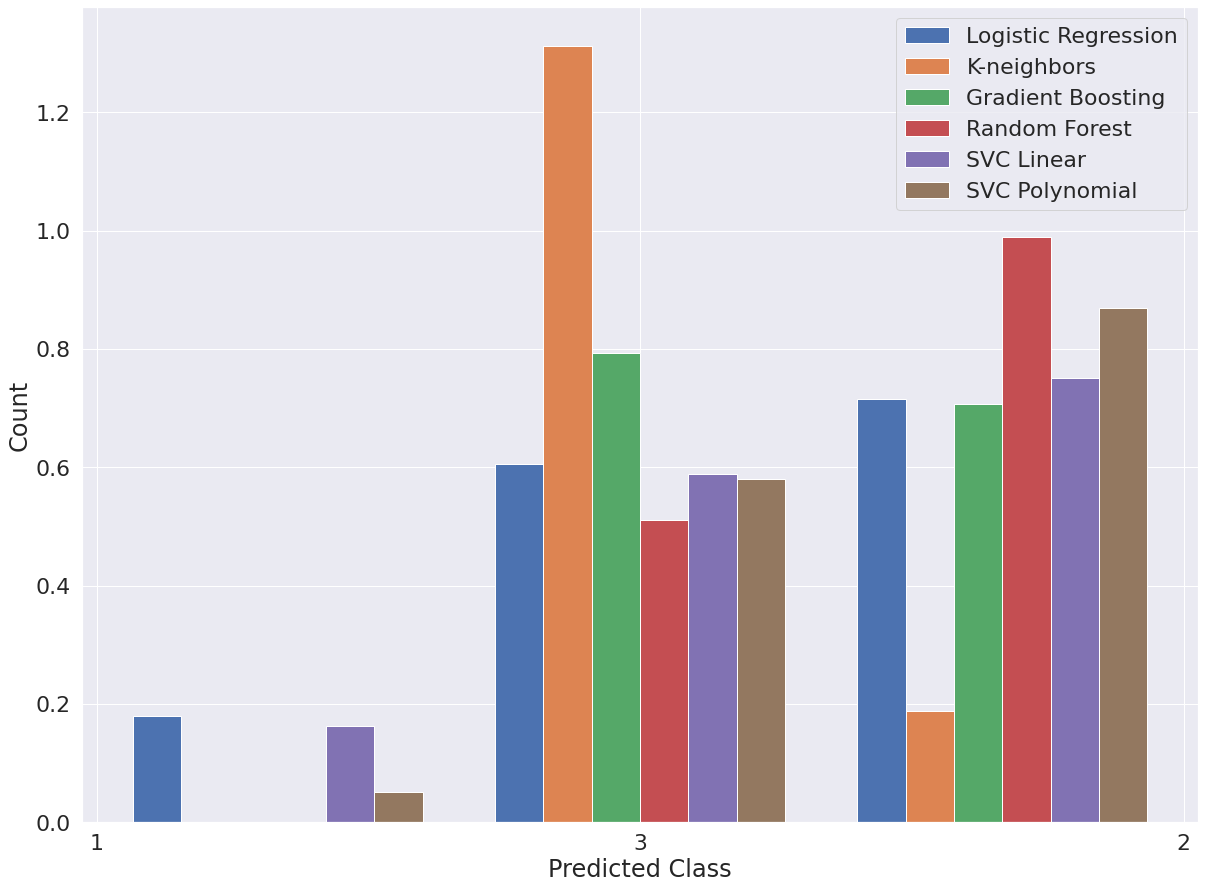

In [79]:
plt.figure(figsize=(20,15))
ax = plt.gca()
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Count')
sns.set(font_scale=2.0)
label_font = {'size':'8'} 
plt.hist(x=(lr,kn,gb, rf, svcl, svcp), label=('Logistic Regression', 'K-neighbors','Gradient Boosting', 
                                              'Random Forest','SVC Linear', 'SVC Polynomial'),bins=3, density=True)
plt.legend()